In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
df=pd.read_csv('data_balita.csv')
df.head()

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted


# Data Understanding

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


In [ ]:
df.describe()

,Umur (bulan),Tinggi Badan (cm)
count,120999.000000,120999.000000
mean,30.173803,88.655434
std,17.575119,17.300997
min,0.000000,40.010437
25%,15.000000,77.000000
50%,30.000000,89.800000
75%,45.000000,101.200000
max,60.000000,128.000000


In [ ]:
df.isnull().sum()

,0
Umur (bulan),0
Jenis Kelamin,0
Tinggi Badan (cm),0
Status Gizi,0


In [ ]:
jumlah_duplikat = df.duplicated().sum()
print(f"Jumlah duplikat: {jumlah_duplikat}")

Jumlah duplikat: 81574


# Data Preparation

## hapus data duplikat

In [ ]:
df = df.drop_duplicates()
print(f' data duplikat: {df.duplicated().sum()}')
df.info()

 data duplikat: 0
<class 'pandas.core.frame.DataFrame'>
Index: 39425 entries, 0 to 120993
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Umur (bulan)       39425 non-null  int64  
 1   Jenis Kelamin      39425 non-null  object 
 2   Tinggi Badan (cm)  39425 non-null  float64
 3   Status Gizi        39425 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


## Melakukan Mapping pada kolom kategorikal

In [ ]:
df['Label_kelamin'] = df['Jenis Kelamin'].map({'laki-laki': 0, 'perempuan': 1})
df['Label_Gizi'] = df['Status Gizi'].map({'severely stunted': 0, 'stunted': 1, 'normal': 2, 'tinggi': 3})
df

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi,Label_kelamin,Label_Gizi
0,0,laki-laki,44.591973,stunted,0,1
1,0,laki-laki,56.705203,tinggi,0,3
2,0,laki-laki,46.863358,normal,0,2
3,0,laki-laki,47.508026,normal,0,2
4,0,laki-laki,42.743494,severely stunted,0,0
...,...,...,...,...,...,...
120959,60,perempuan,100.700000,normal,1,2
120967,60,perempuan,113.700000,normal,1,2
120968,60,perempuan,107.500000,normal,1,2
120972,60,perempuan,127.600000,tinggi,1,3


## EDA

<ipython-input-9-47c7609ad52c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=jenis_kelamin.index, y=jenis_kelamin.values, palette="pastel")


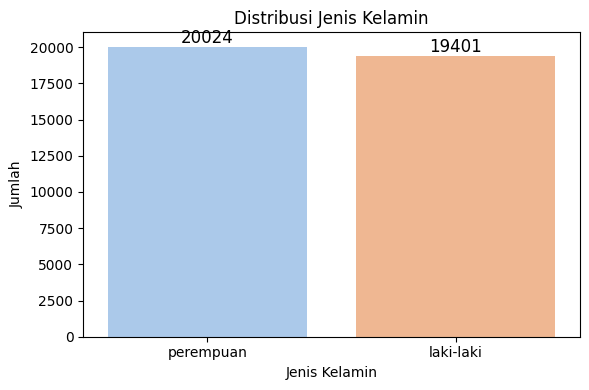

In [ ]:


jenis_kelamin = df['Jenis Kelamin'].value_counts()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=jenis_kelamin.index, y=jenis_kelamin.values, palette="pastel")

for i, value in enumerate(jenis_kelamin.values):
    ax.text(i, value + 0.05, str(value), ha='center', va='bottom', fontsize=12)

plt.title('Distribusi Jenis Kelamin')
plt.xlabel('Jenis Kelamin')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()


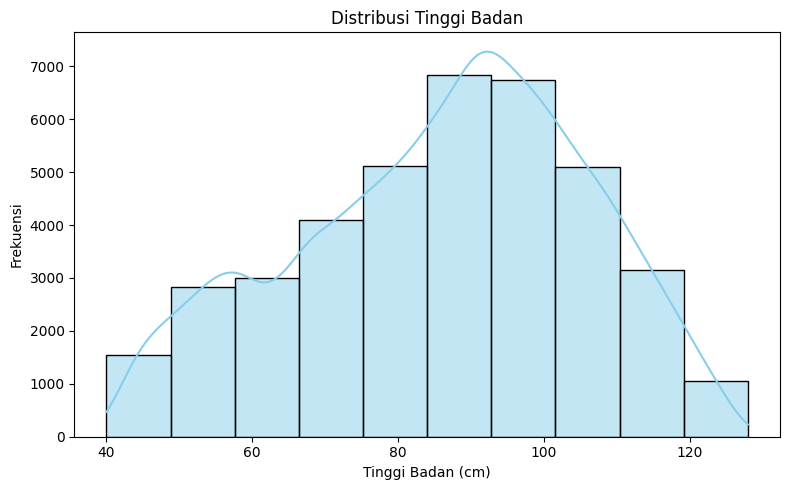

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Tinggi Badan (cm)'], kde=True, bins=10, color='skyblue')
plt.title('Distribusi Tinggi Badan')
plt.xlabel('Tinggi Badan (cm)')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()


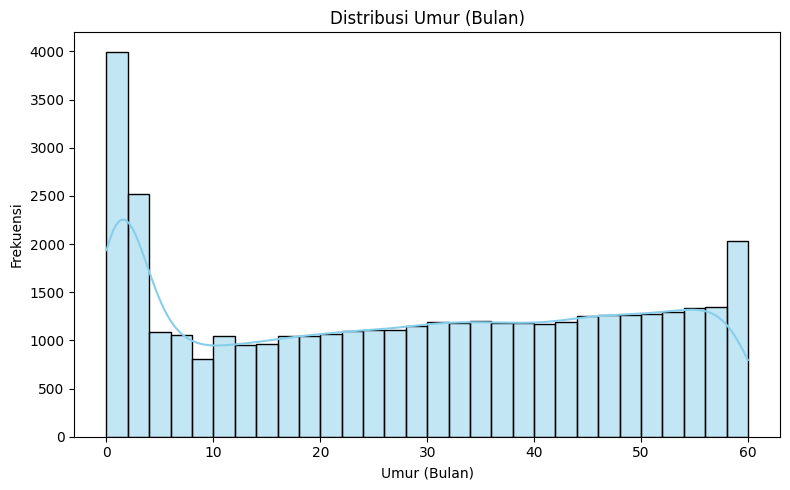

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Umur (bulan)'], kde=True, bins=30, color='skyblue')
plt.title('Distribusi Umur (Bulan)')
plt.xlabel('Umur (Bulan)')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()


<ipython-input-12-b3d21664e989>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Status Gizi', data=df, palette='Set2')


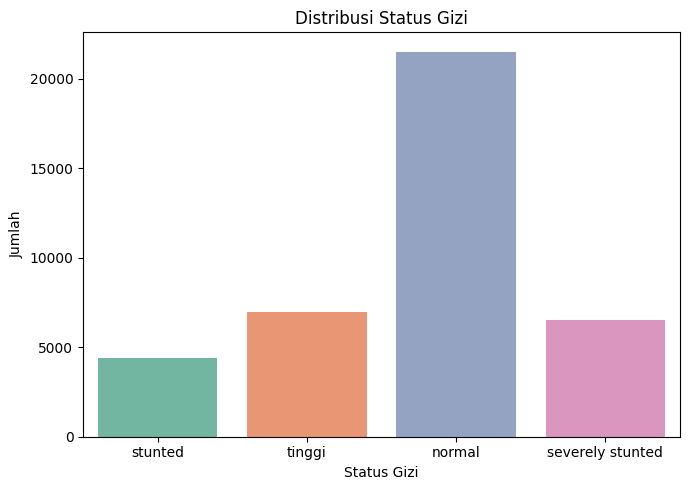

In [ ]:
plt.figure(figsize=(7, 5))
sns.countplot(x='Status Gizi', data=df, palette='Set2')
plt.title('Distribusi Status Gizi')
plt.xlabel('Status Gizi')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

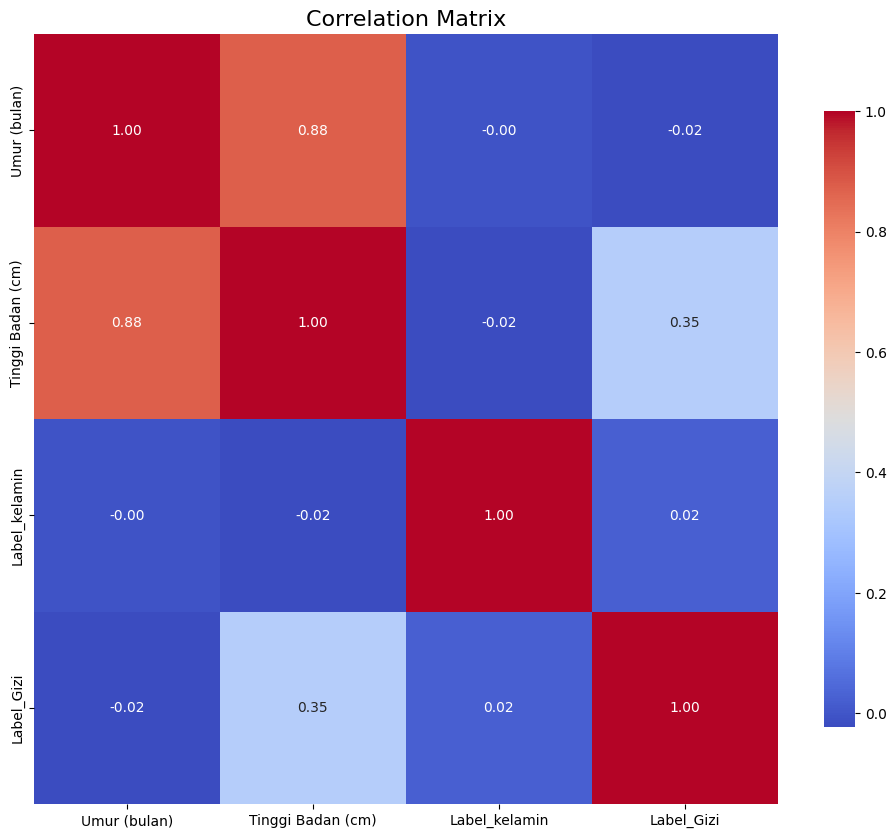

In [ ]:
numerical_features = df.select_dtypes(include=np.number)

correlation_matrix = numerical_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'shrink': 0.8}, annot_kws={'size': 10})
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [ ]:
X = df[['Umur (bulan)', 'Tinggi Badan (cm)', 'Label_kelamin']]
y = df['Label_Gizi']
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# lalu split ke train dan test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Penggunaan compute_class_weight bertujuan untuk menyamakan kontribusi dari setiap kelas dalam proses pelatihan model, dengan cara menghitung bobot proporsional berdasarkan distribusi frekuensi masing-masing kelas. Dengan demikian, kelas yang memiliki jumlah sampel lebih sedikit akan diberikan bobot lebih besar, sehingga model tidak bias terhadap kelas mayoritas dan dapat mengenali kelas minoritas dengan lebih akurat

In [ ]:


# Hitung bobot untuk setiap kelas
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Konversi ke dictionary
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


Class weights: {0: np.float64(1.5192678227360308), 1: np.float64(2.2031293657446214), 2: np.float64(0.4590975254730713), 3: np.float64(1.4090421729807006)}


# Membuat Model

In [ ]:
num_features = X_train.shape[1]
num_classes = len(y.unique())

model = Sequential([
    Dense(64, activation='relu', input_shape=(num_features,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)





/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    ModelCheckpoint(
        filepath='Model_stunting.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
]

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weights_dict

)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,468 (9.64 KB)

 Trainable params: 2,468 (9.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
781/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.1947
Epoch 1: val_accuracy improved from -inf to 0.66424, saving model to Model_stunting.h5


789/789 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4384 - loss: 1.1926 - val_accuracy: 0.6642 - val_loss: 0.7764 - learning_rate: 0.0010
Epoch 2/50
776/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6531 - loss: 0.7081
Epoch 2: val_accuracy improved from 0.66424 to 0.75301, saving model to Model_stunting.h5


789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6536 - loss: 0.7071 - val_accuracy: 0.7530 - val_loss: 0.5568 - learning_rate: 0.0010
Epoch 3/50
788/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7374 - loss: 0.5425
Epoch 3: val_accuracy improved from 0.75301 to 0.83497, saving model to Model_stunting.h5


789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7374 - loss: 0.5424 - val_accuracy: 0.8350 - val_loss: 0.4206 - learning_rate: 0.0010
Epoch 4/50
774/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7746 - loss: 0.4582
Epoch 4: val_accuracy did not improve from 0.83497
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7748 - loss: 0.4578 - val_accuracy: 0.8294 - val_loss: 0.3810 - learning_rate: 0.0010
Epoch 5/50
786/789 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8020 - loss: 0.4093
Epoch 5: val_accuracy improved from 0.83497 to 0.87635, saving model to Model_stunting.h5


789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8020 - loss: 0.4093 - val_accuracy: 0.8763 - val_loss: 0.3128 - learning_rate: 0.0010
Epoch 6/50
781/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8165 - loss: 0.3740
Epoch 6: val_accuracy improved from 0.87635 to 0.89062, saving model to Model_stunting.h5


789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8165 - loss: 0.3740 - val_accuracy: 0.8906 - val_loss: 0.2793 - learning_rate: 0.0010
Epoch 7/50
779/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8317 - loss: 0.3501
Epoch 7: val_accuracy improved from 0.89062 to 0.89553, saving model to Model_stunting.h5


789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8317 - loss: 0.3500 - val_accuracy: 0.8955 - val_loss: 0.2521 - learning_rate: 0.0010
Epoch 8/50
770/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8390 - loss: 0.3307
Epoch 8: val_accuracy improved from 0.89553 to 0.89632, saving model to Model_stunting.h5


789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8391 - loss: 0.3304 - val_accuracy: 0.8963 - val_loss: 0.2469 - learning_rate: 0.0010
Epoch 9/50
774/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8495 - loss: 0.3130
Epoch 9: val_accuracy improved from 0.89632 to 0.90235, saving model to Model_stunting.h5


789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8495 - loss: 0.3129 - val_accuracy: 0.9023 - val_loss: 0.2378 - learning_rate: 0.0010
Epoch 10/50
780/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8532 - loss: 0.3023
Epoch 10: val_accuracy did not improve from 0.90235
789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8532 - loss: 0.3023 - val_accuracy: 0.8985 - val_loss: 0.2367 - learning_rate: 0.0010
Epoch 11/50
779/789 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8552 - loss: 0.3047
Epoch 11: val_accuracy improved from 0.90235 to 0.91487, saving model to Model_stunting.h5


789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8553 - loss: 0.3044 - val_accuracy: 0.9149 - val_loss: 0.2121 - learning_rate: 0.0010
Epoch 12/50
777/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8703 - loss: 0.2725
Epoch 12: val_accuracy did not improve from 0.91487
789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8703 - loss: 0.2724 - val_accuracy: 0.8971 - val_loss: 0.2266 - learning_rate: 0.0010
Epoch 13/50
774/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8677 - loss: 0.2688
Epoch 13: val_accuracy improved from 0.91487 to 0.93421, saving model to Model_stunting.h5


789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8677 - loss: 0.2688 - val_accuracy: 0.9342 - val_loss: 0.1839 - learning_rate: 0.0010
Epoch 14/50
784/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8735 - loss: 0.2602
Epoch 14: val_accuracy did not improve from 0.93421
789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8735 - loss: 0.2602 - val_accuracy: 0.9266 - val_loss: 0.1821 - learning_rate: 0.0010
Epoch 15/50
769/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8791 - loss: 0.2542
Epoch 15: val_accuracy did not improve from 0.93421
789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8790 - loss: 0.2541 - val_accuracy: 0.9288 - val_loss: 0.1748 - learning_rate: 0.0010
Epoch 16/50
779/789 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8812 - loss: 0.2465
Epoch 16: val_accuracy did not improve from 0.93421
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8812 - loss: 0.2466 - val_accuracy: 0.9185 - val_loss: 0.1903 - learning_rate: 0.0010
Epoch 17/50
777/789

789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8946 - loss: 0.2176 - val_accuracy: 0.9356 - val_loss: 0.1573 - learning_rate: 0.0010
Epoch 24/50
770/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8920 - loss: 0.2308
Epoch 24: val_accuracy did not improve from 0.93564
789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8921 - loss: 0.2306 - val_accuracy: 0.9352 - val_loss: 0.1533 - learning_rate: 0.0010
Epoch 25/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8942 - loss: 0.2249
Epoch 25: val_accuracy did not improve from 0.93564
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8942 - loss: 0.2249 - val_accuracy: 0.9271 - val_loss: 0.1706 - learning_rate: 0.0010
Epoch 26/50
776/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8954 - loss: 0.2118
Epoch 26: val_accuracy did not improve from 0.93564
789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8954 - loss: 0.2119 - val_accuracy: 0.9331 - val_loss: 0.1677 - learning_rate: 0.0010
Epoch 27/50
767/789

789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8969 - loss: 0.2194 - val_accuracy: 0.9509 - val_loss: 0.1354 - learning_rate: 0.0010
Epoch 28/50
774/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8956 - loss: 0.2184
Epoch 28: val_accuracy did not improve from 0.95086
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.2184 - val_accuracy: 0.9212 - val_loss: 0.1736 - learning_rate: 0.0010
Epoch 29/50
780/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8931 - loss: 0.2211
Epoch 29: val_accuracy did not improve from 0.95086
789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8932 - loss: 0.2212 - val_accuracy: 0.9158 - val_loss: 0.1823 - learning_rate: 0.0010
Epoch 30/50
784/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8979 - loss: 0.2205
Epoch 30: val_accuracy did not improve from 0.95086
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8979 - loss: 0.2205 - val_accuracy: 0.9442 - val_loss: 0.1423 - learning_rate: 0.0010
Epoch 31/50
774/789

789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9174 - loss: 0.1692 - val_accuracy: 0.9512 - val_loss: 0.1194 - learning_rate: 2.0000e-04
Epoch 43/50
779/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9186 - loss: 0.1763
Epoch 43: val_accuracy did not improve from 0.95117
789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9186 - loss: 0.1763 - val_accuracy: 0.9432 - val_loss: 0.1301 - learning_rate: 2.0000e-04
Epoch 44/50
776/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9168 - loss: 0.1689
Epoch 44: val_accuracy did not improve from 0.95117
789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9168 - loss: 0.1689 - val_accuracy: 0.9412 - val_loss: 0.1322 - learning_rate: 2.0000e-04
Epoch 45/50
784/789 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9186 - loss: 0.1663
Epoch 45: val_accuracy did not improve from 0.95117
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9186 - loss: 0.1664 - val_accuracy: 0.9507 - val_loss: 0.1200 - learning_rate: 2.0000e-04
Epo

789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9167 - loss: 0.1699 - val_accuracy: 0.9569 - val_loss: 0.1120 - learning_rate: 2.0000e-04
Epoch 48/50
783/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9178 - loss: 0.1749
Epoch 48: val_accuracy did not improve from 0.95688
789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9178 - loss: 0.1749 - val_accuracy: 0.9383 - val_loss: 0.1359 - learning_rate: 2.0000e-04
Epoch 49/50
771/789 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9159 - loss: 0.1675
Epoch 49: val_accuracy did not improve from 0.95688
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9159 - loss: 0.1675 - val_accuracy: 0.9426 - val_loss: 0.1290 - learning_rate: 2.0000e-04
Epoch 50/50
777/789 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9155 - loss: 0.1738
Epoch 50: val_accuracy improved from 0.95688 to 0.95767, saving model to Model_stunting.h5


789/789 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9156 - loss: 0.1737 - val_accuracy: 0.9577 - val_loss: 0.1109 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 50.


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9588 - loss: 0.1094
Test accuracy: 0.9551
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
severel=df[df['Status Gizi']=="severely stunted"]
sevdannormal=df[(df['Status Gizi']=="severely stunted") |(df['Status Gizi']=="normal")]
tinggi=df[df['Status Gizi']=="tinggi"]
tinggi

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi,Label_kelamin,Label_Gizi
1,0,laki-laki,56.705203,tinggi,0,3
6,0,laki-laki,59.572523,tinggi,0,3
9,0,laki-laki,57.201961,tinggi,0,3
17,0,laki-laki,57.422319,tinggi,0,3
21,0,laki-laki,56.487869,tinggi,0,3
...,...,...,...,...,...,...
120707,60,perempuan,124.700000,tinggi,1,3
120723,60,perempuan,126.500000,tinggi,1,3
120770,60,perempuan,126.100000,tinggi,1,3
120955,60,perempuan,126.200000,tinggi,1,3


In [ ]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

model = load_model('Model_stunting.h5')

scaler = joblib.load('scaler.pkl')

new_data = pd.DataFrame({
    'Umur (bulan)': [0, 59, 18],
    'Tinggi Badan (cm)': [44.591973	, 92, 123],
    'Jenis Kelamin': ['laki-laki', 'perempuan', 'laki-laki']
})


new_data['Label_kelamin'] = new_data['Jenis Kelamin'].map({'laki-laki': 0, 'perempuan': 1})
X_new = new_data[['Umur (bulan)', 'Tinggi Badan (cm)', 'Label_kelamin']]

X_new_scaled = scaler.transform(X_new)

predictions = model.predict(X_new_scaled)

predicted_classes = np.argmax(predictions, axis=1)

status_gizi_mapping = {0: 'severely stunted', 1: 'stunted', 2: 'normal', 3: 'tinggi'}
predicted_status_gizi = [status_gizi_mapping[i] for i in predicted_classes]

print("New Data:")
print(new_data)
print("\nPredicted Status Gizi:")
for i in range(len(new_data)):
    print(f"Data point {i+1}: {predicted_status_gizi[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
New Data:
   Umur (bulan)  Tinggi Badan (cm) Jenis Kelamin  Label_kelamin
0             0          44.591973     laki-laki              0
1            59          92.000000     perempuan              1
2            18         123.000000     laki-laki              0

Predicted Status Gizi:
Data point 1: stunted
Data point 2: severely stunted
Data point 3: tinggi


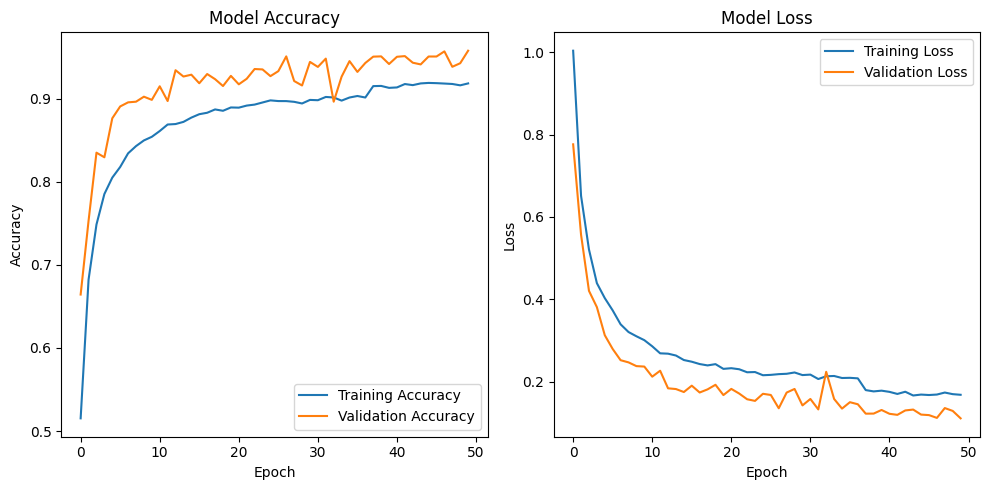

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
!pip install tensorflowjs
import tensorflowjs as tfjs

tfjs_model_dir = 'tfjs_model'

tfjs.converters.save_keras_model(model, tfjs_model_dir)

print(f"Model saved in TensorFlow.js format to '{tfjs_model_dir}'")

